# Intro to Cartolan - Trade Winds
This script will document the rules of the boardgame Cartolan, and set up for simulations of it to be run.

In Cartolan, it is the age of exploration, an age of sails and trails and wonders from the far side of the world. Race along established trade routes, amassing goods, and then set out into the unknown and see what new treasures you can discover and bring back successfully to the Capital. Perhaps you'll be the first to discover the Mythical City on the far side of the world, or to earn your place in history by completing the Mappa Mundi, or simply to secure your legacy by winning the lucrative Carta Mundi. But, always remember, there are rivals for your glory, and they may not be above a little piracy!

## Contents of this guide / structure of the investigation:
1. [Game items and class definitions](#-1.-Game-items-and-class-templates)
2. [Quick references and method definitions](#-2.-Quick-references-and-method-definitions)
+ Beginner mode - exploration and trade by sea
+ Regular mode - inland exploration, and piracy
+ Advanced mode - special skills, sicknesses and seasons
3. [Setup before play and instantiation of objects](#-3.-Setup-before-play-and-instantiation-of-objects)
4. Detailed instructions for play and procedural structure of game
5. Tips from human play and an exploration of simulated strategies
+ Human discovered tips
+ Basic simulation of edge case strategies testing the diversity of gameplay
+ RHMN-SORN background and construction
+ Simulation derived strategies

# 1. Game items and class templates

The game itself involves up to four players, each of which can have various pieces which are placed on tiles around the play area, and can take actions that lead to movement of those pieces or more tiles being drawn from tile piles and placed around the play area.

There are three different modes for the game, with successively more rules: Beginner, Regular, and Advanced.

In [3]:
class Game:
    MAX_PLAYERS = 4
    MIN_PLAYERS = 2
    num_players = 2
    players = []
    turn_order = []
    
    tile_piles = {}
    play_area = {"0":{}}
    
    gusting_wind_die = None
    
    turn = 0
    winner = None
    
    #some information to keep track of centrally for players to make decisions
    agent_network = None #placeholder to keep track of which routes are possible in a single turn
    agent_distances = [[]] #placeholder to keep track of where trade routes could be built
    most_lucrative_route_value = 0
    most_lucrative_route_player = None
    
    def __init__(self, num_players, game_mode, gusting_wind_die):
        self.num_players = num_players
        self.game_mode = game_mode
        self.gusting_wind_die = gusting_wind_die

## Items per player / colour

### Player and player mat (x1)

There can be between two and four players per game, and each one can hold wealth tokens in their Vault which determine who wins the game, as well as having Adventurer and Agent tokens which can each hold wealth tokens themselves.

In [5]:
class Player:
    game = None
    
    colour = "Red"
    
    vault_wealth = 0
    
    adventurers = []
    
    agents = []
    
    def __init__(self, game, colour):
        self.game = game
        self.colour = colour

### Adventurer tokens (x3)

These cylindrical numbered tokens are the moveable pieces for each player, with different movement possible between tiles over water edges with or against the wind, or over land edges - whether onto existing tiles or exploring new spaces. Each one can collect wealth, in its Chest, and can potentially take on pirate status carrying a Pirate token:
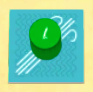

In [11]:
class Token:
    game = None
    player = None
    current_tile = None
    wealth = 0
    
    def __init__(self, game, player, current_tile, wealth):
        self.game = game
        self.player = player
        self.current_tile = current_tile
        self.wealth = wealth

class Adventurer(Token):
    max_downwind_moves = 4
    downwind_moves = 0
    max_upwind_moves = 1
    upwind_moves = 0
    max_land_moves = 2
    land_moves = 0
    
    max_exploration_attempts = 5
    exploration_attempts = 0
    
    pirate_token = False
    
    latest_city = None
    
    def move(self, compass_point):
        #placeholder for movement
        return None
        
    def explore(self, latitude, longitude):
        #placeholder for exploration
        return None
        
    def discover(self, tile):
        #placeholder for discovering new wealth
        return None
        
    def trade(self, tile):
        #placeholder for trading on a suitable tile
        return None
        
    def rest(self, agent):
        #placeholder for resting with an agent
        return None
    
    def attack(self, token):
        #placeholder for attacking other tokens in Regular and Advanced modes
        return None

### Agent tokens (x5)

These cubic tokens, which are plain on five sides and marked on the sixth with a skull'n'crossbones, can be placed in a fixed position during the game, where they will help Adventurers perform various actions:
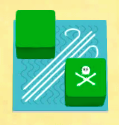

In [12]:
class Agent(Token):
    disabled = False
    
    def give_rest(self, adventurer):
        #placeholder for resting adventurers
        return None
    
    def manage_trade(self, adventurer):
        #placeholder for agents involved in trade on a tile
        return None

## Items shared by all players

<!-- ### Movement compass (x1) -->

### Exploration compass (x1)
This large square tile contains visuals to remind players of how tiles are rotated during exploration. They do not play any other roles in gameplay and so are not worth simulating. 
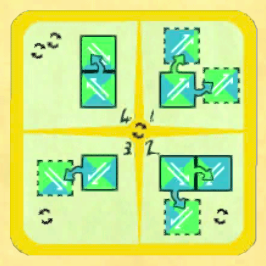

### Conflict guide (x1)
This sheet contains visuals to remind players of how different conflicts resolve. They do not play any other roles in gameplay and so are not worth simulating. 


### Pirate token (x12)
These black disc tokens, with skull'n'crossbones on both sides, are moved around with an Adventurer token once they have committed piracy, to represent the fact they have abandoned all but essential gear to aid movement at the expense of being able to present themselves in a civilised manner for trading. They do any other roles in gameplay and so are not worth simulating.
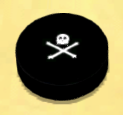

### Small wealth token (x50)
These many white discs each represent 1 wealth point, and would be used in the physical game to keep track of wealth collected in Adventurer's Chests, on top of Agents and Disaster tiles, and in each Player's Vault. They do not play any other roles in gameplay and so are not worth simulating. 
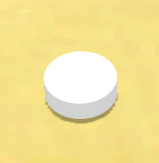

### Big wealth token (x50)
These many white squares each represent 5 wealth points, and would be used in the physical game to keep track of wealth collected in Adventurer's Chests, on top of Agents and Disaster tiles, and in each Player's Vault. They do not play any other roles in gameplay and so are not worth simulating. 

### Gusting Wind die
This six sided die has five faces with wind arrows pointing straight to indicate wind gusting with the prevailing wind, and one face with a wind arrow curving around to indicate wind gusting against the prevailing wind. It is used in Regular game mode to allow more upwind movement and to settle conflicts.
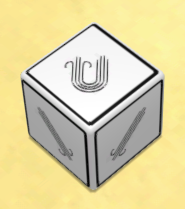

In [16]:
class GustingWindDie:
    game = None
    
    import random
    random.seed() # defaults to system time
    
    NUM_FACES = 6
    NUM_GUST_AGAINST_WIND_FACES = 1
    
    def roll_gust_against_wind(self):
        if random.random() < NUM_GUST_AGAINST_WIND_FACES/NUM_FACES: # careful, in Python2 integer division won't produce a float
            return True
        else:
            return False

## Tiles
The game takes place across square tiles that have been laid next to one another in a grid, drawn from tile piles, and which determine what actions players' tokens can take each movement and how they earn wealth. Each tile will have four edges that can be either water or land, and an arrow denoting wind direction diagonally across them. On the back of the tile there will be either land or water. Only water-backed tiles are used in Beginner mode. Tiles may also have a pearl/diamond denoting a Wonder on that tile or a skull'n'crossbones denoting a disaster.
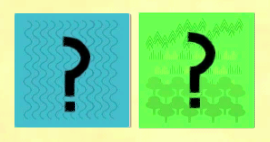 | 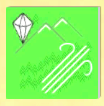 | 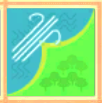

In [37]:
class TilePosition:
    # keep track of the tile's position in two ints
    latitude = 0
    longitude = 0
    
    def __init__(self, latitude, longitude):
        self.latitude = latitude
        self.longitude = longitude


class WindDirection:
    # keep track of the wind direction with two bits
    north = True 
    east = True
    
    def __init__(self, north, east):
        self.north = north
        self.east = east

        
class TileEdges:
    # keep track of the edges of the tile in four bits
    upwind_clock_water = True #can abbreviate uc later
    upwind_anti_water = True #can abbreviate ua later
    downwind_clock_water = True #can abbreviate dc later
    downwind_anti_water = True  #can abbreviate da later
    
    def __init__(self, uc_water, ua_water, dc_water, da_water):
        self.upwind_clock_water = uc_water
        self.upwind_anti_water = ua_water
        self.downwind_clock_water = dc_water
        self.downwind_anti_water = da_water


class Tile:
    game = None
    tile_back_water = True
    
    tile_position = TilePosition(latitude = 0, longitude = 0)
    wind_direction = WindDirection(north = True, east = True)
    tile_edges = TileEdges(uc_water = True, ua_water = True, dc_water = True, da_water = True)
    
    adventurers = [] # to keep track of the tokens on a tile at any point
    agent = None
    
    def __init__(self, game, tile_back_water, tile_position, wind_direction, tile_edges):
        self.game = game
        self.tile_back_water = tile_back_water
        self.tile_position = tile_position
        self.wind_direction = wind_direction
        self.tile_edges = tile_edges
    
    def place_tile(self, latitude, longitude):
        play_area = self.game.play_area
        if play_area.get(latitude) is None:
            play_area[latitude] = {longitude:self}
            self.tile_position = TilePosition(latitude, longitude)
        elif play_area.get(latitude).get(longitude) is None: 
            play_area[latitude][longitude] = self
            self.tile_position = TilePosition(latitude, longitude)
        else: raise Exception("Tried to place a tile on top of another")
    
    def rotate_tile_clock(self):
        #NE->SE, SE->SW, SW->NW, NW->NE
        if self.wind_direction.north and self.wind_direction.east:
            self.wind_direction.north = False
        elif not self.wind_direction.north and self.wind_direction.east:
            self.wind_direction.east = False
        elif not self.wind_direction.north and not self.wind_direction.east:
            self.wind_direction.north = True
        elif self.wind_direction.north and not self.wind_direction.east:
            self.wind_direction.east = True
        else: raise Exception("Tile orientations have become confused")
    
    def rotate_tile_anti(self):
        #NE->NW, NW->SW, SW->SE, SE->NE
        if self.wind_direction.north and self.wind_direction.east:
            self.wind_direction.east = False
        elif self.wind_direction.north and not self.wind_direction.east:
            self.wind_direction.north = False
        elif not self.wind_direction.north and not self.wind_direction.east:
            self.wind_direction.east = True
        elif not self.wind_direction.north and self.wind_direction.east:
            self.wind_direction.north = True
        else: raise Exception("Tile orientations have become confused")
    
    def compass_edge_water(self, compass_point):
        if self.wind_direction.north and self.wind_direction.east: # NE orientation => N = downwind anti
            if lower(compass_point) in ["north", "n"]:
                return self.tile_edges.downwind_anti_water
            elif lower(compass_point) in ["east", "e"]:
                return self.tile_edges.downwind_clock_water
            elif lower(compass_point) in ["south", "s"]:
                return self.tile_edges.upwind_anti_water
            elif lower(compass_point) in ["west", "w"]:
                return self.tile_edges.upwind_clock_water
            else: raise Exception("Tile orientations have become confused")
        elif not self.wind_direction.north and self.wind_direction.east: # SE orientation => N = upwind clock 
            if lower(compass_point) in ["north", "n"]:
                return self.tile_edges.upwind_clock_water
            elif lower(compass_point) in ["east", "e"]:
                return self.tile_edges.downwind_anti_water
            elif lower(compass_point) in ["south", "s"]:
                return self.tile_edges.downwind_clock_water
            elif lower(compass_point) in ["west", "w"]:
                return self.tile_edges.upwind_anti_water
            else: raise Exception("Tile orientations have become confused")
        elif not self.wind_direction.north and not self.wind_direction.east: # SW orientation => N = upwind anti
            if lower(compass_point) in ["north", "n"]:
                return self.tile_edges.upwind_anti_water
            elif lower(compass_point) in ["east", "e"]:
                return self.tile_edges.upwind_clock_water
            elif lower(compass_point) in ["south", "s"]:
                return self.tile_edges.downwind_anti_water
            elif lower(compass_point) in ["west", "w"]:
                return self.tile_edges.downwind_clock_water
            else: raise Exception("Tile orientations have become confused")
        elif self.wind_direction.north and not self.wind_direction.east: # NW orientation => N = downwind clock
            if lower(compass_point) in ["north", "n"]:
                return self.tile_edges.downwind_clock_water
            elif lower(compass_point) in ["east", "e"]:
                return self.tile_edges.upwind_anti_water
            elif lower(compass_point) in ["south", "s"]:
                return self.tile_edges.upwind_clock_water
            elif lower(compass_point) in ["west", "w"]:
                return self.tile_edges.downwind_anti_water
            else: raise Exception("Tile orientations have become confused")
        else: raise Exception("Tile orientations have become confused")
    
    
    def compass_edge_downwind(self, compass_point):
        if lower(compass_point) in ["north","n"]:
            return self.wind_direction.north
        elif lower(compass_point) in ["east","e"]:
            return self.wind_direction.east
        elif lower(compass_point) in ["south","s"]:
            return not self.wind_direction.north
        elif lower(compass_point) in ["west","w"]:
            return not self.wind_direction.east
        else: raise Exception("Invalid compass direction checked")
        
    
    def move_onto_tile(self, token):
        if isinstance(token, Token):
            if isinstance(token, Adventurer):
                self.adventurers.append(token)
                
            elif isinstance(token, Agent):
                if self.agent is None:
                    self.agent = token
                if self.agent.disabled:
                    self.agent.current_tile = None
                    self.agent = token
                else: raise Exception("Tried to add multiple Agents to a tile")
            else: raise Exception("Didn't know how to handle this kind of token")
        else: raise Exception("Tried to move something other than a token onto a tile")
    
    def move_off_tile(self, token):
        if token is self.agent:
            self.agent.current_tile = None
            self.agent = None
        
        if self.adventurers.contains(token):
            self.adventurers.remove(token)
        else: raise Exception("Tried to remove a token that was never on the tile")
        

class TilePile:
    import random
    
    tile_back_water = True
    
    tiles = []
    
    def __init__(self, tile_back_water, tiles):
        self.tile_back_water = tile_back_water
        self.tiles = tiles
    
    def add_tile(self, tile):
        if isinstance(tile, Tile):
            if tile.tile_back_water == tile_back_water:
                self.tiles.append(tile)
            else: raise Exception ("Tried adding a tile to the wrong pile")
        else: raise Exception("Tried adding something other than a tile to a pile")
    
    def draw_tile(self):
        return self.tiles.pop()
    
    def shuffle_tiles(self):
        random.shuffle(self.tiles)

### Water tiles
These tiles will tend to have more water edges, and can include Wonders that give wealth for discovery or trade, encouraging play balancing speed of travel with the time interval before banking wealth in a player's Vault.
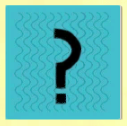

In [38]:
class WaterTileDistribution():
    tile_back_water = True;

### Land tiles
These tiles will tend to have more land edges and can include both Wonders, that give wealth for discovery or trade, and Disasters, that remove all wealth from an Adventurer, encouraging play balancing risk against greater reward. 
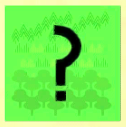

In [39]:
class LandTile(Tile):
    tile_back_water = False

### City tiles - The Capital and The Mythical City
These tiles allow players to move wealth from an Adventurer's Chest to the Player's Vault, as well as investing wealth in more Adventurers or Agents. You can move in any direction from these tiles as if every edge was land. 

In [40]:
class CityTile(LandTile):
    isCapital = True
    isDiscovered = True
    tile_edges = TileEdges(uc_water = False, ua_water = False, dc_water = False, da_water = False)
    tile_position = TilePosition(latitude = 0, longitude = 0)
    
    def __init__(self, isCapital, isDiscovered, tile_position):
        self.isCapital = isCapital
        self.isDiscovered = isDiscovered
        self.tile_position = tile_position
    
    def visit_city(adventurer):
        #placeholder for interactions between an Adventurer and city
        return None
        
    def bank_wealth(adventurer, wealth_to_bank):
        #placeholder for letting players move wealth from an adventurer's Chest to their Vault
        return None
    
    def buy_adventurer(adventurer):
        #placeholder for letting players buy another Adventurer using wealth from their Vault
        return None
        
    def buy_agent(adventurer, tile):
        #placeholder for letting players buy another Agent using wealth from their Vault
        return None

# 2. Quick references and method definitions

## Beginner mode - Exploration and Trade by sea

In [41]:
class GameBeginner(Game):    
    MAX_ADVENTURERS = 3
    MAX_AGENTS = 5
    
    VALUE_DISCOVER_WONDER = {"water":5}
    VALUE_TRADE = 2
    VALUE_AGENT_TRADE = 1
    VALUE_DISABLE_AGENT = 1
    
    COST_AGENT_ON_DISCOVERY = 3
    COST_AGENT_FROM_CITY = 5
    COST_AGENT_REST = 1
    COST_AGENT_RESTORE = 1
    
    EXPLORATION_ATTEMPTS = 5
    MAX_DOWNWIND_MOVES = 4
    MAX_LAND_MOVES = 2
    MAX_UPWIND_MOVES = 1    

### Adventurers
Adventurers start out at cities and can each move over up to 4 edges between tiles each turn, or after resting at an Agent during a turn. There are two possible variants for their movement:

1. Budgetted - Within these 4 moves, they can cross land edges (green) at most 2 times or can cross a water edge (blue) 1 time against the direction of the Wind Arrow on the tile they move from. 
2. Initial only - After their first turn, the player cannot move across a water edge (blue) against the direction of the Wind Arrow on the tile they move from. After their second move they cannot cross land edges (green).

After a move onto another tile, or using a move to wait on the same tile, an Adventurer can trade as part of that same move. Resting at a player’s own Agents is free, but 1 wealth is left with another player’s Agent. 

If they are moving into an empty space with no tile, then [exploration](###-Exploration---placing-new-tiles:) will be needed.

### Exploration - placing new tiles: 
When an Adventurer moves into an empty space, a new tile should be drawn to fill that space from the pile, and placed so that the edges match colour with all adjacent tiles. The wind direction should be matched, but if it doesn’t fit then there are two possible variants on how to try different rotations of the tile:

1. Continuous wind - the tile should be tried rotated 90 degrees so that the wind arrow from their previous tile still flows into the base of the new arrow, then tried rotated 90 degrees the other way.
2. Clockwise first - the tile should be tried rotated clockwise, then anticlockwise.

If the tile cannot fit with its surrounding tiles, or only with the arrow pointing in the opposite direction from the previous tile, then it is put in the discard pile and up to four more tiles tried that move.

In [52]:
class AdventurerBeginner(Adventurer):
    game = GameBeginner()
    max_exploration_attempts = game.EXPLORATION_ATTEMPTS
    max_downwind_moves = game.MAX_DOWNWIND_MOVES
    max_land_moves = game.MAX_LAND_MOVES
    max_upwind_moves = game.MAX_upwind_moves
    
    wonders_visited = []
    
    def can_move_budgetted(self, compass_point): #this version A of movement allows land and upwind movement any time, but a limited number before resting
        # check that instruction is valid: only one direction
        if not (lower(compass_point) in ["north","n","east","e","south","s","west","w"]): raise Exception("invalid direction given for movement")
        
        # check whether move is possible over the edge
        if not self.current_tile.compass_edge_water(compass_point): #land movement needed
            if(self.land_moves < self.max_land_moves and self.upwind_moves == 0):
                return True
        elif self.current_tile.compass_edge_water(compass_point) and self.current_tile.compass_edge_downwind(compass_point): #downwind movement possible
            if (self.downwind_moves < self.max_downwind_moves):
                return True
        else: #if not land or downwind, then movement must be upwind
            if(self.upwind_moves < self.max_upwind_moves and self.land_moves == 0):
                return True
            else: return False
    
    def can_move_initial(self, compass_point): #this version A of movement allows land and upwind movement any time, but a limited number before resting
        # check that instruction is valid: only one direction
        if not (lower(compass_point) in ["north","n","east","e","south","s","west","w"]): raise Exception("invalid direction given for movement")
        
        # check whether move is possible over the edge
        moves_since_rest = self.land_moves + self.downwind_moves + self.upwind_moves
        if not self.current_tile.compass_edge_water(compass_point): #land movement needed
            if(moves_since_rest < self.max_land_moves):
                return True
        elif self.current_tile.compass_edge_water(compass_point) and self.current_tile.compass_edge_downwind(compass_point): #downwind movement possible
            if (moves_since_rest < self.max_downwind_moves):
                return True
        else: #if not land or downwind, then movement must be upwind
            if(moves_since_rest < self.max_upwind_moves):
                return True
            else: return False
    
    def exploration_needed(self, latitude, longitude):
        return self.game.play_area.get(latitude) is None or self.game.play_area.get(latitude).get(longitude) is None
    
    def move(self, compass_point):
        # check whether the next tile exists and explore if needed
        #if can_move_budgetted(compass_point): #@TODO make this an option that is selectable
        if not can_move_initial(compass_point):
            return False
        
        latitude_increment = int(lower(compass_point) in ["north","n"]) - int(lower(compass_point) in ["south","s"])
        new_latitude = self.current_tile.tile_position.latitude + latitude_increment
        longitude_increment = int(lower(compass_point) in ["east","e"]) - int(lower(compass_point) in ["west","w"])
        new_longitude = self.current_tile.tile_position.longitude + longitude_increment
        
        #is this an existing tile or is exploration needed?
        if exploration_needed(new_latitude, new_longitude):
            for exploration_attempt in range(1, self.max_exploration_attempts):
                if self.explore(new_latitude, new_longitude):
                    self.current_tile = self.game.play_area.get(new_latitude).get(new_longitude)
                    self.current_tile.move_onto_tile(self)
                    # if this is a Wonder then discovery should be automatic
                    if isinstanceof(self.current_tile, WonderTile):
                        self.discover(self.current_tile)
                    return True             
            return False   
                
        else: #place the Adventurer on this Tile
            self.current_tile = self.game.play_area.get(latitude).get(longitude)
            self.current_tile.move_onto_tile(self) 
            return True
    
    def explore_clockwise(self, latitude, longitude):
        # establish which pile to draw from - always the water tile in beginner mode
        tile_pile = game.tile_piles["water"]
        
        # draw a tile from the pile
        tile = tile_pile.draw_tile()
        
        # check whether the tile will place, rotating as needed
        #first get the adjoining edges from the neighbouring tiles, if any
        for neighbour_latitude in [latitude - 1, latitude + 1]:
            if not self.game.play_area.get(neighbour_latitude) is None:
                if not self.game.play_area.get(neighbour_latitudde).get(longitude) is None:
                    self.game.play_area.get(neighbour_latitudde).get(longitude).
        for neighbour_longitude in [longitude - 1, longitude + 1]:
        
        # place tile and discover or don't 
        
        # feed back to calling function that a tile has been placed
                              
    def explore(self, latitude, longitude):
        self.explore_clockwise(latitude, longitude)
        #self.explore_continuous(latitude, longitude) # should make this an option
        
    def discover(self, tile):
        #check whether this tile is inside a city's domain, four or less tiles from it by taxi norm
        
        #award wealth if not
        
        #trade instead if so
        
        
    def trade(self, tile):
        #confirm that this tile is a Wonder
        
        # check whether there is an Agent on the tile
        
        # collect appropriate wealth into Chest
        
        # keep track of visiting this Wonder
        wonders_visited.append(tile)
        
    
    def rest(self, agent):
        # check whether the agent belongs to the same player
        
        # pay as necessary
        
        # reset move count

IndentationError: expected an indented block (<ipython-input-52-5ba1db9b6757>, line 82)

In [49]:
test_dict = {1:{1:"tt", -3:"kk"}, 2:{1: "ll"}}

test_dict.get(3)
test_dict.get(3).get(2)
test_dict.get(1).get(2)

AttributeError: 'NoneType' object has no attribute 'get'

### Agents
Agents can be placed on any new tile more than four tiles from a city, costing the moving Adventurer 3 wealth. If placed on a Wonder tile, an Agent will collect 1 wealth whenever a Trade takes place on that tile, collected by the player’s next visiting Adventurer. An Agent is disabled if an opponent’s Adventurer successfully attacks it, awarding them all the wealth it was holding plus 1. An Agent is restored by its own player’s Adventurer visiting and paying 1 wealth.

In [ ]:
class AgentBeginner(Agent):
    def give_rest(self, adventurer):
        #check whether Adventurer is from same player and charge if other player
        
        #reset move counts for adventurer
    
    def manage_trade(self, adventurer):
        #check whether Adventurer trading is from the same player
        
        #retain wealth if they are a different player
        
        #give Adventurer wealth if same player

### Cities (Capital and Mythical): 
Within four moves of a city in any directions, Agents cannot be placed and discovering new Wonders gives no wealth. When finishing a move in a city you can move wealth from an Adventurer’s Chest into the player’s Vault, and buy another Adventurer for 10 wealth. You can also place an Agent on any tile that doesn’t have an active Agent or an opponent’s Adventurer for 5 wealth, or where you have an Adventurer for 3 wealth. Victory is awarded to the player with the most wealth in their Vault, either when one player is more than 25 ahead, or when one colour of tile runs out.

In [ ]:
class CityTileBeginner(CityTile):
    def visit_city(adventurer):
        #record that this is the latest city visited
    
    def bank_wealth(adventurer, wealth_to_bank):
        #placeholder for letting players move wealth from an adventurer's Chest to their Vault
        
        #reset Adventurer's list of visited Wonders
    
    
    def buy_adventurer(adventurer):
        #check that player has appropriate wealth in the Vault, and subtract if available
        
        #place another Adventurer for this Player on the City tile
        
        
    def buy_agent(adventurer, tile):
        #check that the player has requisite wealth in their Vault
        
        #check whether the tile already has an active Agent, if there is a disabled Agent then remove it 
        
        #place the Agent on that tile

### Wonders
When turned over these tiles grant 5 wealth to the Adventurer. Subsequent visits will grant 2 wealth from Trade, but only once for each Adventurer between visits to a city.

In [ ]:
class WonderTile(Tile):
    def reward_discovery(adventurer):
        #check what kind of tile this is and look up the reward
        
        #add wealth to Adventurer's Chest
    
    def reward_trade(adventurer):
        #check that adventurer has not visited this tile already since their last visit to a city
        
        #check whether there is an active Agent on this tile and involve them in the trade if so

## Regular mode - inland exploration and piracy

### Attacking - Piracy and Arrest
An Adventurer can attack another (non-pirate) Adventurer or Agent immediately on the tile where they finish a move. They become a pirate, then carrying the Pirate token. Until they visit a city, they cannot trade, or rest at other players’ Agents, but they can move onto and off Disaster tiles as if all the edges were land. When an Adventurer attacks another player, or tries to arrest a pirate on the same tile, they only succeed if two rolls of the die don’t match. Successful attack against an Adventurer takes half their wealth, against an Agent takes all their wealth plus one, and against a pirate removes all their wealth, returns them to their last city and awards 5 wealth to the arrester’s Vault.

In [ ]:
class AdventurerRegular(AdventurerBeginner):
    pirate_token = False
        
    def attack(self, token):
        # have opponent roll for defence
        
        # roll for attack
        
        # compare rolls
        
        # resolve conflict

### Disaster tiles
When first turned over these tiles send the moving Adventurer back to the Capital. All the wealth from their Chest is left on the tile. Half this wealth at a time can then be recovered by visiting pirates as if being attacked by the disaster.

In [ ]:
class DisasterTile(Tile):
    dropped_wealth = 0
    
    def move_onto_tile(self, token):
        if isinstance(token, Token):
            if isinstance(token, Adventurer):
                # check if the Adventurer has a Pirate token
                
                # otherwise send the Adventurer to the capital and keep their wealth
                
                self.adventurers.append(token)
            else if isinstance(token, Agent) raise Exception("Tried to add Agent to a disaster tile")
        else raise Exception("Tried to move something other than a token onto a tile")
    
    def move_off_tile(self, token):
        if self.adventurers.contains(token):
            self.adventurers.remove(token)
        else raise Exception("Tried to remove a token that was never on the tile")
    
    def attack_adventurer(self, adventurer):
        if AdventurerRegular.attack(adventurer):
            # otherwise send the Adventurer to the capital and keep their wealth
            

            

### Inland exploration
Unlike beginner mode, when an Adventurer moves over a tile edge into an empty space, a new tile should be drawn from the pile of the same colour as that edge. When one of these tiles has Wonder, the player turning it over is rewarded with 10 wealth.

### Upwind and unburdened movement
If an Adventurer’s Chest is empty, then they move up to three times across land edges (green) between tiles, or up to twice over water edges (blue) against the direction of the wind arrow on the tile they move from, since starting their turn or resting. After these allotted upwind moves, the player may roll a gust against the prevailing wind on the die in order to move across a water edge upwind.

## Advanced mode - special skills, sicknesses, and seasons

# 3. Setup before play and instantiation of objects

## 1. The Capital tile is placed
The Capital tile is placed, and a plain water tile on every side of it. It is recommended that the prevailing wind should point towards the North-East on all these tiles in a 2 or 3 player game, while in a 4 player game the West and North tiles should point South-West.

## 2. Each player places an Adventurer token on the Capital tile
Each player places an Adventurer token on the Capital tile, or if they want a faster,  more unpredictable, game all can also place a second.

## 3. Remaining Adventurers and Agents are placed with Player mat
Their remaining Adventurer tokens should be placed on each player's mat, in their correspondingly numbered Chests. 5 Agent tokens should be placed in the Vault.

## 4. A pile of Water Tiles is drawn
A shared pile of water tiles is randomly drawn, with 30 tiles for each player.

## 5. A pile of Land Tiles is drawn
For Regular or Advanced mode, a shared pile of land tiles is randomly drawn, with 15 tiles for each player.

## 6. The Mythical City tile is placed
Place the Mythical City tile 10 tiles east of the Capital City surrounded by four plain water tiles with the prevailing wind mirroring the Capital tile, for example pointing towards the South-West in the recommended 2/3 player setup.

## 7. Select the starting player
Starting with the youngest, players each roll the Gusting Wind die until someone gets a gust against the prevailing wind roll, which selects them as the starting player.